# PatchTST model for Time Series Forecasting

### Import libraries

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from torch.utils.data import TensorDataset, DataLoader
import math

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Preparing sample time series data

In [15]:
# 1. 시계열 데이터 생성 (sin + noise)
np.random.seed(42)
t = np.arange(0, 500)
data = np.sin(0.05 * t) + 0.1 * np.random.randn(500)
data = data.reshape(-1, 1)  # (500, 1)

# 2. 정규화
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# 3. 슬라이딩 윈도우 생성
def create_inout_sequences(data, input_window, output_window):
    in_seq, out_seq = [], []
    L = len(data)
    for i in range(L - input_window - output_window):
        train_seq = data[i:i+input_window]
        train_label = data[i+input_window:i+input_window+output_window]
        in_seq.append(train_seq)
        out_seq.append(train_label)
    return np.array(in_seq), np.array(out_seq)

input_window = 48
output_window = 24
X, y = create_inout_sequences(data_scaled, input_window, output_window)

# 4. Tensor 변환
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)  # (B, input_window, 1)
y_tensor = torch.tensor(y, dtype=torch.float32).to(device)  # (B, output_window, 1)


In [16]:
print("X shape:", X_tensor.shape)
print("y shape:", y_tensor.shape)

X shape: torch.Size([428, 48, 1])
y shape: torch.Size([428, 24, 1])


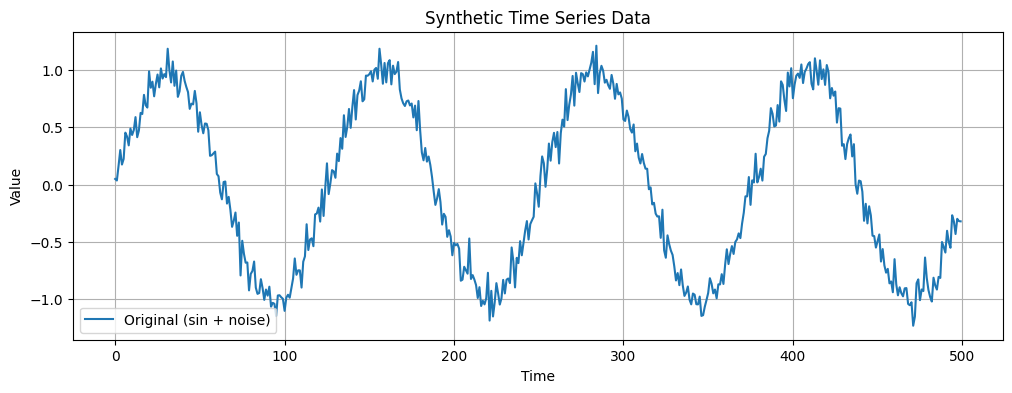

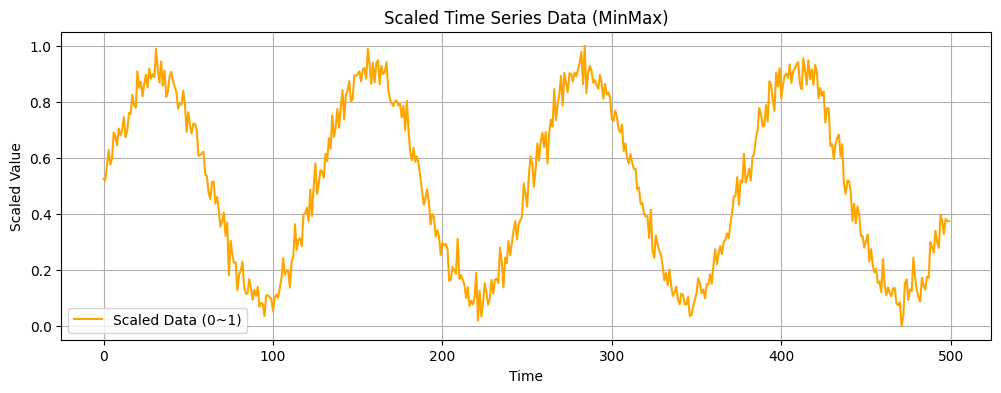

In [17]:
# 시계열 데이터 시각화 (정규화 전 원본)
plt.figure(figsize=(12, 4))
plt.plot(t, data, label="Original (sin + noise)")
plt.title("Synthetic Time Series Data")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

# 시계열 데이터 시각화 (MinMaxScaler 적용 후)
plt.figure(figsize=(12, 4))
plt.plot(data_scaled, label="Scaled Data (0~1)", color='orange')
plt.title("Scaled Time Series Data (MinMax)")
plt.xlabel("Time")
plt.ylabel("Scaled Value")
plt.legend()
plt.grid(True)
plt.show()

### Patch Embedding

In [18]:
class PatchEmbedding(nn.Module):
    def __init__(self, input_window, patch_size, input_dim, d_model):
        super().__init__()
        self.patch_size = patch_size
        self.num_patches = input_window // patch_size

        # Linear projection: patch (patch_size x input_dim) → d_model
        self.proj = nn.Linear(patch_size * input_dim, d_model)

    def forward(self, x):
        """
        x: (B, input_window, input_dim) = (B, 48, 1)
        → 나눠서 (B, num_patches, patch_size * input_dim)
        """
        B, L, D = x.shape
        assert L % self.patch_size == 0, "input_window must be divisible by patch_size"

        # (B, 48, 1) → (B, num_patches, patch_size, input_dim)
        x = x.view(B, self.num_patches, self.patch_size, D)

        # (B, num_patches, patch_size * input_dim)
        x = x.flatten(start_dim=2)

        # (B, num_patches, d_model)
        return self.proj(x)


### PatchTST

In [19]:
class PatchTST(nn.Module):
    def __init__(self, input_window, patch_size, input_dim, d_model, output_window, num_layers=2, nhead=4, dropout=0.1):
        super().__init__()
        self.embedding = PatchEmbedding(input_window, patch_size, input_dim, d_model)

        # Positional Encoding (선택적으로 추가 가능하지만 여기선 생략 가능)
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=256,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)

        # 출력층: d_model → output_window
        self.decoder = nn.Linear(d_model, output_window)

    def forward(self, x):
        """
        x: (B, input_window, input_dim)
        output: (B, output_window, 1)
        """
        x = self.embedding(x)          # (B, num_patches, d_model)
        x = self.encoder(x)            # (B, num_patches, d_model)
        x = x.mean(dim=1)              # (B, d_model)
        x = self.decoder(x)            # (B, output_window)
        return x.unsqueeze(-1)         # (B, output_window, 1)

### Hyperparameter Setting and Model Initialization

In [20]:
# 하이퍼파라미터 설정
input_window = 48
patch_size = 12
input_dim = 1
d_model = 64
output_window = 24
num_layers = 2
nhead = 4
dropout = 0.1
learning_rate = 1e-3
batch_size = 32
num_epochs = 30

# 모델 초기화
model = PatchTST(
    input_window=input_window,
    patch_size=patch_size,
    input_dim=input_dim,
    d_model=d_model,
    output_window=output_window,
    num_layers=num_layers,
    nhead=nhead,
    dropout=dropout
).to(device)

### Training the model

In [21]:
# 손실 함수: MSE
criterion = nn.L1Loss()

# 옵티마이저 설정
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# DataLoader 구성
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 학습 루프
for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        output = model(xb)               # (B, output_window, 1)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch}, Loss: {avg_loss:.4f}")


Epoch 1, Loss: 0.3006
Epoch 2, Loss: 0.1778
Epoch 3, Loss: 0.1067
Epoch 4, Loss: 0.0797
Epoch 5, Loss: 0.0705
Epoch 6, Loss: 0.0647
Epoch 7, Loss: 0.0616
Epoch 8, Loss: 0.0611
Epoch 9, Loss: 0.0623
Epoch 10, Loss: 0.0616
Epoch 11, Loss: 0.0636
Epoch 12, Loss: 0.0590
Epoch 13, Loss: 0.0573
Epoch 14, Loss: 0.0554
Epoch 15, Loss: 0.0553
Epoch 16, Loss: 0.0548
Epoch 17, Loss: 0.0560
Epoch 18, Loss: 0.0524
Epoch 19, Loss: 0.0520
Epoch 20, Loss: 0.0519
Epoch 21, Loss: 0.0529
Epoch 22, Loss: 0.0506
Epoch 23, Loss: 0.0502
Epoch 24, Loss: 0.0499
Epoch 25, Loss: 0.0483
Epoch 26, Loss: 0.0503
Epoch 27, Loss: 0.0513
Epoch 28, Loss: 0.0507
Epoch 29, Loss: 0.0481
Epoch 30, Loss: 0.0486


### Prediction -> Post-processing

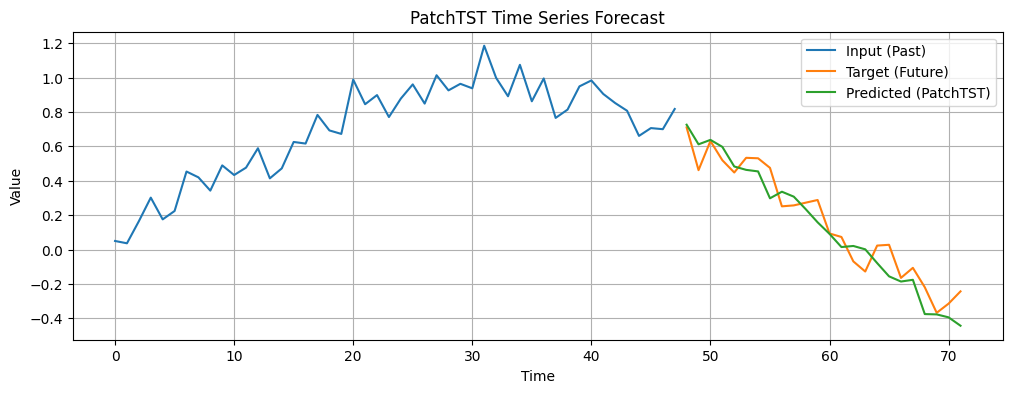

In [25]:
# 평가 모드 전환 및 예측 수행
model.eval()
with torch.no_grad():
    sample_input = X_tensor[0].unsqueeze(0)         # (1, input_window, 1)
    prediction = model(sample_input)                # (1, output_window, 1)

# 차원 정리
predicted = prediction.squeeze().cpu().numpy()      # (output_window,)
actual = y_tensor[0].squeeze().cpu().numpy()        # (output_window,)
input_seq = X_tensor[0].squeeze().cpu().numpy()     # (input_window,)

# 정규화 복원 (역변환)
input_original = scaler.inverse_transform(input_seq.reshape(-1, 1)).flatten()
target_original = scaler.inverse_transform(actual.reshape(-1, 1)).flatten()
predicted_original = scaler.inverse_transform(predicted.reshape(-1, 1)).flatten()

# 시각화
plt.figure(figsize=(12, 4))
plt.plot(range(input_window), input_original, label='Input (Past)')
plt.plot(range(input_window, input_window + output_window), target_original, label='Target (Future)')
plt.plot(range(input_window, input_window + output_window), predicted_original, label='Predicted (PatchTST)')
plt.title("PatchTST Time Series Forecast")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)

# save and show
plt.savefig("sin_result/PatchTST_sin_function_forecast.png", bbox_inches='tight')
plt.show()